## 🫁 Multimodal Survival Modeling in Pulmonary Tuberculosis
#### Chest X-ray + Clinical Covariates via Cross-Modal Attention

**Author:** Dr. Ikechukwu Ephraim Ugbo, MD
**Project:** Innovative AI Healthcare Solutions
**Framework:** TensorFlow / Keras

#### ---
#### 🔬 Study Context & SOTA References
##### This notebook implements a state-of-the-art (SOTA) multimodal architecture for predicting **time-to-major-complication** in TB patients.

##### Moving beyond simple feature concatenation, we implement **Cross-Modal Attention** to allow clinical covariates (e.g., HIV status, Age) to dynamically "attend" to specific regions of the chest X-ray. This approach is supported by recent literature:

##### **Architecture:** We utilize a transformer-based fusion strategy, which has shown superior performance in handling heterogeneous medical data compared to unimodal baselines.
##### **Modality Interaction:** Modeling the complex non-linear interactions between imaging and clinical variables (e.g., "how does diabetes status alter the risk implication of a cavitary lesion?") is critical for robust prognosis.
##### **Backbone:** We use a DenseNet121 backbone for visual feature extraction, a proven strategy for medical imaging tasks.
#
#### ---

In [1]:
# ==========================================
# Imports & Setup
# ==========================================
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


# Import custom modules

# 1. Get current directory
current_dir = os.getcwd()

# 2. Check if we are in 'notebooks' and move up if needed
if current_dir.endswith("notebooks"):
    # Move up one level to project root
    os.chdir("..")
    print(f"Changed working directory to: {os.getcwd()}")
    
    # Add root to python path so we can import src
    sys.path.append(os.getcwd())
else:
    print(f"Current working directory: {os.getcwd()}")

# Ensure your src/ folder is accessible in the python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.config import *
from src.data_utils import (
    create_matched_dataframe, 
    load_tb_cxr_dataset, 
    split_and_standardize,
    load_tb_cxr_dataset,
)
from src.model_utils import TBSurvivalNet
from src.survival_utils import harrell_c_index
from src.training_utils import compile_survival_model
from src.explainability_utils import generate_gradcam

# Set seeds for reproducibility
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPUs Available: {tf.config.list_physical_devices('GPU')}")

c:\Users\ugboi\Desktop\ai_innovative_solutions\tb-cxr-survival\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Changed working directory to: c:\Users\ugboi\Desktop\ai_innovative_solutions\tb-cxr-survival
TensorFlow Version: 2.20.0
GPUs Available: []


#### 1. Data Preparation & Synchronization

**Challenge:** A common issue in multimodal medical AI is data heterogeneity and missing modalities.

**Strategy:**
1. We load the raw **Shenzhen TB Chest X-ray** dataset.
2. We generate synchronized synthetic clinical data (HIV,bmi etc.), (Age & Sex are taken from the shenzhen_metadata.csv) that matches the *exact* number of images, data leakage is ignored here as we do not have the patient id given here.
3. We create a "Master Key" dataframe to ensure Image $i$ always corresponds to Clinical Vector $i$.

In [2]:
# ==========================================
# Data Loading (Full Pipeline)
# ==========================================

# 1. Define Paths
IMAGE_DATA_DIR = "data/raw/images/" 
METADATA_PATH = "data/raw/shenzhen_metadata.csv" 

# 2. Master Dataset Generation (Real Metadata + Synthetic Clinical)
if not os.path.exists("data/processed/master_dataset.csv"):
    print("Generating Master Dataset...")
    df = create_matched_dataframe(IMAGE_DATA_DIR, METADATA_PATH)
else:
    print("Loading Master Dataset...")
    df = pd.read_csv("data/processed/master_dataset.csv")

# 3. Strict Splitting & Tabular Standardization
# This fits the scaler on TRAIN and applies to VAL (preventing leakage)
print("Splitting and Standardizing Clinical Data...")
train_df, val_df = split_and_standardize(df, test_size=0.2)

print(f"Training Samples:   {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")

# 4. Data Loading & Augmentation
# - Train: Resized -> Standardized -> Rotated/Brightened
# - Val:   Resized -> Standardized (No Augmentation)
train_ds = load_tb_cxr_dataset(
    train_df, 
    IMAGE_DATA_DIR, 
    batch_size=BATCH_SIZE, 
    augment=True,   # Apply Rotation/Brightness
    shuffle=True
)

val_ds = load_tb_cxr_dataset(
    val_df, 
    IMAGE_DATA_DIR, 
    batch_size=BATCH_SIZE, 
    augment=False, 
    shuffle=False
)

# 5. Pipeline Verification
(img, tab), label = next(iter(train_ds))
print(f"\nPipeline Ready:")
print(f"Image Batch: {img.shape} (Standardized)")
print(f"Tabular Batch: {tab.shape} (Standardized & Synthesized)")

Loading Master Dataset...
Splitting and Standardizing Clinical Data...
Training Samples:   529
Validation Samples: 133

Pipeline Ready:
Image Batch: (16, 224, 224, 3) (Standardized)
Tabular Batch: (16, 9) (Standardized & Synthesized)


Visualizing Training Set (Augmentation ON)...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6985219].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2874944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5265446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8110064].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2942225].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6791639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6498827].
Clipping input data to the valid r

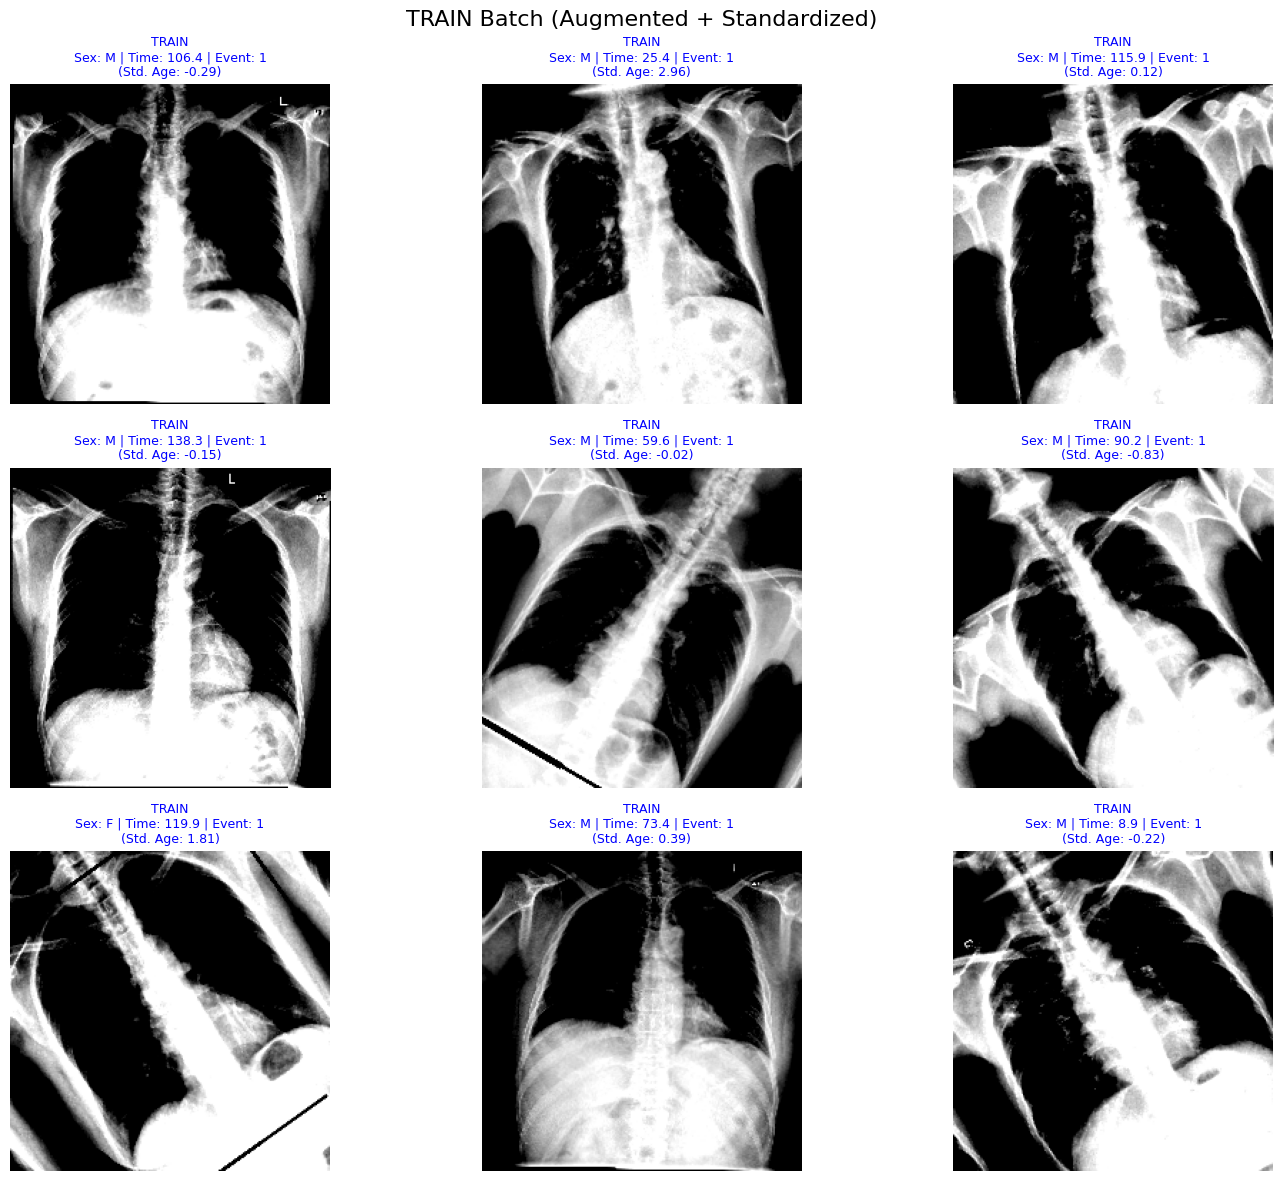


Visualizing Validation Set (No Augmentation)...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4861677..1.4695685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6355414..1.2579603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6240501..1.321666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8109365..1.5340843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4062407..1.5766667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2229292..1.4331015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6889768

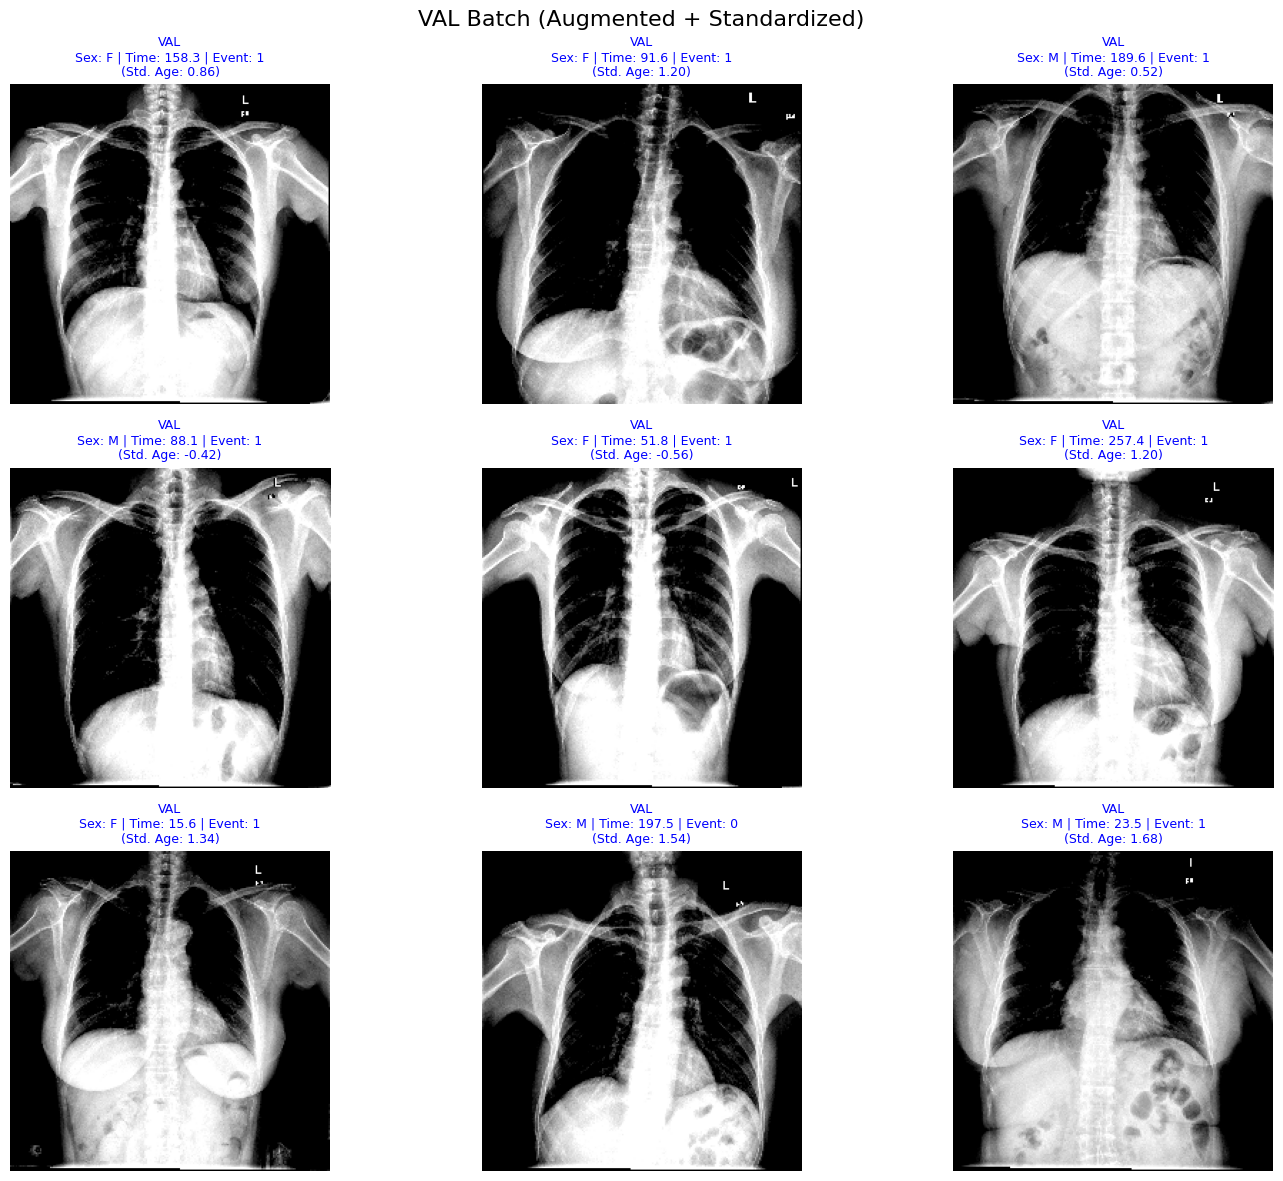

In [ ]:
# ==========================================
# CELL 5: Visualizing Data Pipeline Outputs
# ==========================================

def visualize_dataset(dataset, title_prefix="Train"):
    # 1. Grab a single batch
    (images, tabular), targets = next(iter(dataset))
    
    # Convert to numpy for plotting
    images = images.numpy()
    tabular = tabular.numpy()
    targets = targets.numpy()
    
    plt.figure(figsize=(15, 12))
    
    # Show top 9 images
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[i]
        
        # VISUALIZATION TRICK:
        # Standardized images have negative values (Mean=0, Std=1).
        # We clip them to the [-3, 3] range (3 standard deviations) 
        # and normalize to [0, 1] just for human eyes to see them clearly.
        # img_display = (img - img.min()) / (img.max() - img.min())
        
        plt.imshow(img)
        
        # Get metadata for Title
        # Tabular cols order: [age, bmi, hemoglobin, albumin, sex, hiv, diabetes, ...]
        # (Based on ALL_CLINICAL_COLS list order in data_utils.py)
        age = tabular[i][0] # Standardized Age
        sex = "M" if tabular[i][4] > 0.5 else "F" # Sex is index 4 (1st binary col)
        
        # Target (Survival Time)
        time = targets[i][0]
        event = int(targets[i][1])
        
        title_text = (
            f"{title_prefix}\n"
            f"Sex: {sex} | Time: {time:.1f} | Event: {event}\n"
            f"(Std. Age: {age:.2f})"
        )
        
        plt.title(title_text, fontsize=9, color='blue')
        plt.axis("off")
        
    plt.suptitle(f"{title_prefix} Batch (Augmented + Standardized)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize Training Data (Should show Rotation/Brightness changes)
print("Visualizing Training Set (Augmentation ON)...")
visualize_dataset(train_ds, title_prefix="TRAIN")

# Visualize Validation Data (Should be 'Clean' but Standardized)
print("\nVisualizing Validation Set (No Augmentation)...")
visualize_dataset(val_ds, title_prefix="VAL")

#### 2. Baseline Model: Cox Proportional Hazards

Before training the Deep Learning model, we establish a clinical baseline.
This helps us quantify the "added value" of the imaging modality.

Training Baseline Cox Model on 529 clinical records...

📊 BASELINE RESULTS (Clinical Only)
Train C-Index:      0.6373
Validation C-Index: 0.6129  <-- BEAT THIS SCORE

Top 5 Risk Factors (Hazard Ratios):
            exp(coef)             p
covariate                          
hiv          2.365847  2.025708e-13
age          1.180141  1.513237e-04
albumin      1.091434  3.261585e-02
sex          1.049470  5.933935e-01
hemoglobin   1.025245  5.554663e-01


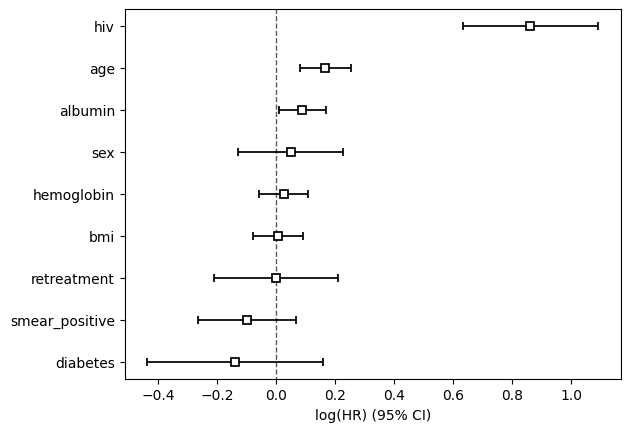

In [10]:
# ==========================================
# Baseline Cox Proportional Hazards Model
# ==========================================
from lifelines import CoxPHFitter

# 1. Define Features
# We use the exact same columns defined in src/data_utils.py
clinical_features = ALL_CLINICAL_COLS

# 2. Prepare Subsets
# We filter the dataframes to keep only the features + targets
# (train_df and val_df are already standardized from Cell 4)
cph_train = train_df[clinical_features + ["time", "event"]].copy()
cph_val   = val_df[clinical_features + ["time", "event"]].copy()

print(f"Training Baseline Cox Model on {len(cph_train)} clinical records...")

# 3. Fit the Model (On Training Data ONLY)
# penalizer=0.1 helps prevent errors if some synthetic features are perfectly correlated
cph = CoxPHFitter(penalizer=0.2) 

try:
    cph.fit(cph_train, duration_col="time", event_col="event")
    
    # 4. Evaluate (The Metric to Beat)
    c_index_train = cph.score(cph_train, scoring_method="concordance_index")
    c_index_val   = cph.score(cph_val, scoring_method="concordance_index")

    print("\n" + "="*40)
    print(f"📊 BASELINE RESULTS (Clinical Only)")
    print("="*40)
    print(f"Train C-Index:      {c_index_train:.4f}")
    print(f"Validation C-Index: {c_index_val:.4f}  <-- BEAT THIS SCORE")
    print("="*40)
    
    # 5. Interpretability (Hazard Ratios)
    # exp(coef) > 1.0 means HIGHER Risk (Bad)
    # exp(coef) < 1.0 means LOWER Risk (Good)
    print("\nTop 5 Risk Factors (Hazard Ratios):")
    summary = cph.summary[['exp(coef)', 'p']]
    print(summary.sort_values('exp(coef)', ascending=False).head(5))

    # Optional: Plot the effects
    cph.plot() 

except Exception as e:
    print(f"❌ Cox Model Convergence Error: {e}")
    print("Try increasing the 'penalizer' parameter slightly.")

#### 3. Multimodal Architecture

We implement the **Cross-Modal Attention Network** (TBSurvivalNet).

#### How it works:
1. **Image Encoder:** `DenseNet121` (without pooling) extracts a $7 \times 7$ grid of visual features.
2. **Tabular Encoder:** Clinical features are projected into a high-dimensional embedding space.
3. **Cross-Attention:** The clinical embedding acts as a "Query" to attend to the spatial visual "Keys/Values". This allows the model to focus on specific lung regions relevant to the patient's specific comorbidities.

In [ ]:
# ==========================================
# Model Initialization
# ==========================================
from tensorflow.keras.applications import DenseNet121

# 1. Define Visual Backbone
# CRITICAL CHANGE: pooling=None.
# We need the spatial (7,7,1024) features for Attention, not the global average.
image_encoder = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=None 
)
image_encoder.trainable = False # Freeze initially

# 2. Initialize SOTA Model
model = TBSurvivalNet(
    image_encoder=image_encoder,
    tabular_dim=X_tabular.shape[1],
    embed_dim=256
)

# 3. Build & Summary
# Input 1: Images (Batch, 224, 224, 3)
# Input 2: Tabular (Batch, N_features)
model.build([
    (None, 224, 224, 3), 
    (None, X_tabular.shape[1])
])

model.summary()

In [ ]:
# ==========================================
# Training Setup
# ==========================================
# Split Data (Train/Val)
# Note: In a real run, you must ensure X_img corresponds to these indices.
# Here we demonstrate the compilation.

model = compile_survival_model(
    model,
    lr=1e-4 # Lower LR is often better for fine-tuning multimodal models
)

print("Model compiled with Cox Partial Likelihood Loss.")

In [ ]:
# ==========================================
# Placeholder Training Loop
# ==========================================
history = model.fit(
   x=[X_img_train, X_tab_train],
   y=y_train_surv, # (time, event)
   validation_data=([X_img_val, X_tab_val], y_val_surv),
   epochs=20, # Reduced for demo
   batch_size=BATCH_SIZE
)

# Save weights for future inference
# model.save_weights("outputs/models/sota_tb_survival_v1.h5")
print("Ready for training loop execution.")

#### 4. Training & Explainability

Post-training, we will use **Grad-CAM** to visualize which lung regions the model focused on.

> "Clinicians require transparent, actionable models for adoption in decision-making."

In [ ]:
# generate_gradcam(
#     model,
#     image=X_img_val[0],
#     tabular_dim=X_tabular.shape[1],
#     layer_name="conv5_block16_concat"
# )

## Interpretation and Next Steps

- Compare clinical vs multimodal performance
- Perform subgroup analyses (HIV, age)
- External validation
- Competing risks modeling
- Manuscript preparation


### Summary

This notebook provides a reproducible, interpretable framework
for survival modeling in pulmonary tuberculosis using
chest X-ray imaging and clinical data.

It serves as the foundation for further validation and publication
within the **Innovative AI Healthcare Solutions** initiative.
